In [82]:
import pandas as pd
import numpy as np
from pandas import Series, DataFrame

import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib import rcParams

import sklearn as sk
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import chi2, RFE
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

import statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor

%matplotlib inline
rcParams['figure.figsize'] = 12, 5
sb.set_style('whitegrid')
np.set_printoptions(suppress=True, precision=3)
pd.set_option('display.precision', 2)

## `Important Note`

- Some Features should not be included like Region_code, State_code, City_code as they dont have significant impact in real-time but consider them while training the model or can be omitted.

- We can see that customers who are **unmarried** are opted out of the campaign of term deposit plan. And there are only 72 rows that have marital status as unknown which would not make a significant impact on the model. It can be removed from the dataset or can be kept as it is.

- Created Synthetic Data using SMOTE

- Features Selected using Recursive Feature Elimination

- RFE on original data - `['age', 'region_code', 'state_code', 'city_code', 'duration', 'campaign',
       'pdays', 'previous', 'postal code', 'employment_indicator',
       'consumer_index', 'economic_sentiment', 'interest_rate_impact',
       'marital_married', 'education_university.degree', 'housing_yes',
       'contact_telephone', 'month_may', 'poutcome_nonexistent',
       'poutcome_success']`

- RFE on synthetic data - `['age', 'state_code', 'city_code', 'duration', 'pdays', 'postal code',
       'employment_indicator', 'consumer_index', 'economic_sentiment',
       'interest_rate_impact', 'job_blue-collar', 'marital_married',
       'marital_single', 'education_high.school',
       'education_university.degree', 'housing_yes', 'contact_telephone',
       'month_may', 'poutcome_nonexistent', 'poutcome_success']`

### Loading the Dataset

In [2]:
df = pd.read_csv('data\\dataset.csv')
df.head()

,customer_id,age,job,marital,education,default,housing,loan,region_code,state_code,...,postal code,city_name,y,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,region_name,state_name
0,1,56,services,married,high.school,no,no,yes,3,S1,...,42420,Henderson,no,1.1,93.994,-36.4,4.857,5191.0,South,Kentucky
1,2,45,services,married,basic.9y,unknown,no,no,3,S1,...,42420,Henderson,no,1.1,93.994,-36.4,4.857,5191.0,South,Kentucky
2,3,59,admin.,married,professional.course,no,no,no,4,S2,...,90036,Los Angeles,no,1.1,93.994,-36.4,4.857,5191.0,West,California
3,4,41,blue-collar,married,unknown,unknown,no,no,3,S3,...,33311,Fort Lauderdale,no,1.1,93.994,-36.4,4.857,5191.0,South,Florida
4,5,24,technician,single,professional.course,no,yes,no,3,S3,...,33311,Fort Lauderdale,no,1.1,93.994,-36.4,4.857,5191.0,South,Florida


In [3]:
df.shape

(37024, 29)

#### Finding the Duplicate values

In [4]:
df[df.duplicated()]

,customer_id,age,job,marital,education,default,housing,loan,region_code,state_code,...,postal code,city_name,y,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,region_name,state_name


- There are no duplicate values in the dataset. But lets see if there are any further duplicate values in the data

In [5]:
duplicate_cities = df.groupby('city_name')['state_name'].nunique().reset_index()
duplicate_cities = duplicate_cities[duplicate_cities['state_name'] > 1]
duplicate_cities

,city_name,state_name


- There are no states that have same city names

In [6]:
df.isnull().sum()

customer_id          0
age                  0
job                  0
marital              0
education            0
default              0
housing              0
loan                 0
region_code          0
state_code           0
city_code            0
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
postal code          0
city_name         4086
y                    0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
region_name          0
state_name           0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37024 entries, 0 to 37023
Data columns (total 29 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   customer_id     37024 non-null  int64  
 1   age             37024 non-null  int64  
 2   job             37024 non-null  object 
 3   marital         37024 non-null  object 
 4   education       37024 non-null  object 
 5   default         37024 non-null  object 
 6   housing         37024 non-null  object 
 7   loan            37024 non-null  object 
 8   region_code     37024 non-null  int64  
 9   state_code      37024 non-null  object 
 10  city_code       37024 non-null  object 
 11  contact         37024 non-null  object 
 12  month           37024 non-null  object 
 13  day_of_week     37024 non-null  object 
 14  duration        37024 non-null  int64  
 15  campaign        37024 non-null  int64  
 16  pdays           37024 non-null  int64  
 17  previous        37024 non-null 

In [8]:
df.drop('customer_id', axis=1, inplace=True)

#### Print the unique values present in all the categorical columns

In [9]:
cat_cols = df.select_dtypes('object').columns
for col in cat_cols:
    print(col, df[col].unique())

job ['services' 'admin.' 'blue-collar' 'technician' 'retired' 'management'
 'unknown' 'entrepreneur' 'housemaid' 'unemployed' 'student'
 'self-employed']
marital ['married' 'single' 'divorced' 'unknown']
education ['high.school' 'basic.9y' 'professional.course' 'unknown' 'basic.6y'
 'basic.4y' 'university.degree' 'illiterate']
default ['no' 'unknown' 'yes']
housing ['no' 'yes' 'unknown']
loan ['yes' 'no' 'unknown']
state_code ['S1' 'S2' 'S3' 'S4' 'S5' 'S6' 'S7' 'S8' 'S9' 'S10' 'S11' 'S12' 'S13'
 'S14' 'S15' 'S16' 'S17' 'S18' 'S19' 'S20' 'S21' 'S22' 'S23' 'S24' 'S25'
 'S26' 'S27' 'S28' 'S29' 'S30' 'S31' 'S32' 'S33' 'S34' 'S35' 'S36' 'S37'
 'S38' 'S39' 'S40' 'S41' 'S42' 'S43' 'S44' 'S45' 'S46' 'S47' 'S48' 'S49']
city_code ['C1' 'C2' 'C3' 'C4' 'C5' 'C6' 'C7' 'C8' 'C9' 'C10' 'C11' 'C12' 'C13'
 'C14' 'C15' 'C16' 'C17' 'C18' 'C19' 'C20' 'C21' 'C22' 'C23' 'C24' 'C25'
 'C26' 'C27' 'C28' 'C29' 'C30' 'C31' 'C32' 'C33' 'C34' 'C35' 'C36' 'C37'
 'C38' 'C39' 'C40' 'C41' 'C42' 'C43' 'C44' 'C45' 'C46'

job
admin.           9403
blue-collar      8297
technician       6087
services         3542
management       2635
retired          1539
entrepreneur     1307
self-employed    1274
housemaid         942
unemployed        925
student           767
unknown           306
Name: count, dtype: int64


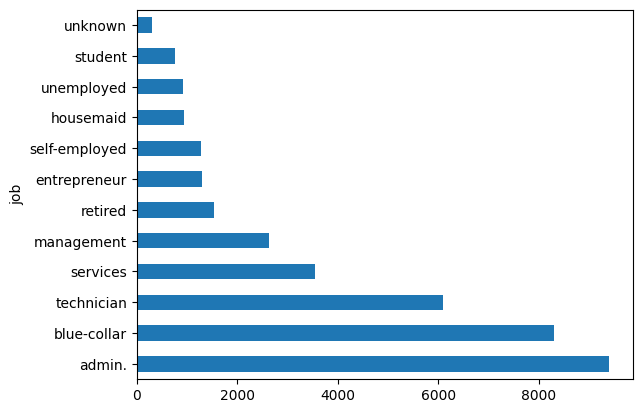

In [10]:
print(df['job'].value_counts())
df['job'].value_counts().plot(kind='barh')
plt.show()

- There are around 306 unknowns which would not have enough impact on the campaign  

marital   y  
divorced  no      3690
          yes      425
married   no     20159
          yes     2288
single    no      8915
          yes     1475
unknown   no        60
          yes       12
Name: count, dtype: int64


<Axes: ylabel='marital,y'>

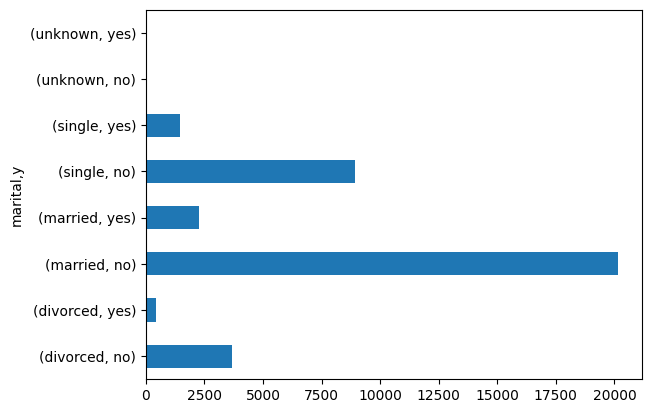

In [11]:
print(df.groupby('marital')['y'].value_counts())
df.groupby('marital')['y'].value_counts().plot(kind='barh')

- We can see that customers who are unmarried are opted out of the campaign of term deposit plan. And there are only 72 rows that have marital status as unknown which would not make a significant impact on the model

In [12]:
len(df[df['marital'] == 'unknown'])

72

In [13]:
df.groupby('education')['y'].value_counts()

education            y  
basic.4y             no     3365
                     yes     391
basic.6y             no     1898
                     yes     171
basic.9y             no     4996
                     yes     418
high.school          no     7589
                     yes     944
illiterate           no       14
                     yes       2
professional.course  no     4201
                     yes     541
university.degree    no     9448
                     yes    1502
unknown              no     1313
                     yes     231
Name: count, dtype: int64

In [14]:
df.groupby('default')['y'].value_counts()

default  y  
no       no     25537
         yes     3798
unknown  no      7285
         yes      402
yes      no         2
Name: count, dtype: int64

- Defaulters mean people who could not repay the bank loans. There are more people who are not defaulters but have opted not to choose or go with the term deposit plan, hence defaulters with unknown category would play a little role in whether they have opted for the term deposit

<Axes: ylabel='job'>

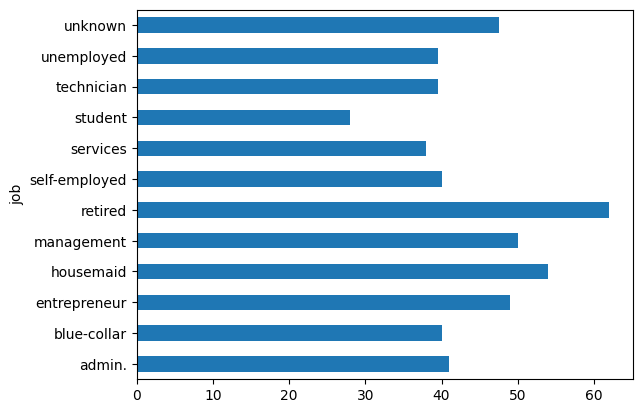

In [15]:
df[(df['default'] == 'unknown') & (df['y'] == 'yes')].groupby('job')['age'].median().plot(kind='barh')

- The people with age in the median between 30 - 60 with job's like admin, blue-collar, entrepreneur, etc have opted for the term deposit plan

housing  y  
no       no     14904
         yes     1833
unknown  no       790
         yes       91
yes      no     17130
         yes     2276
Name: count, dtype: int64


<Axes: ylabel='housing,y'>

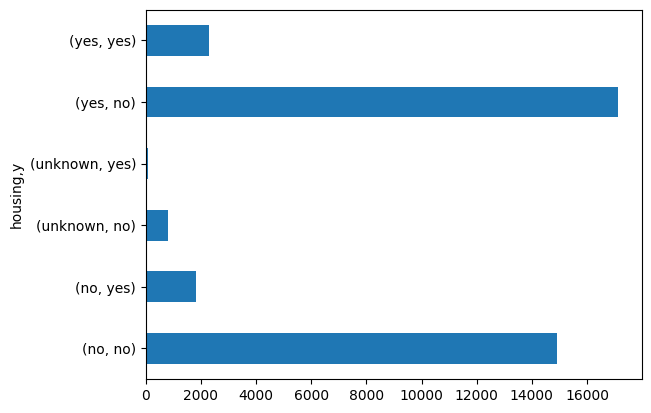

In [16]:
print(df.groupby('housing')['y'].value_counts())
df.groupby('housing')['y'].value_counts().plot(kind='barh')

- People who have housing have opted for going with the term deposit plan. which could play a significant impact on the model to predict the people who are about to opt for the term deposit

In [17]:
df.groupby('loan')['y'].value_counts()

loan     y  
no       no     27021
         yes     3493
unknown  no       790
         yes       91
yes      no      5013
         yes      616
Name: count, dtype: int64

- People who do not have loan mostly have opted out of term deposit plan.

<Axes: ylabel='contact,y'>

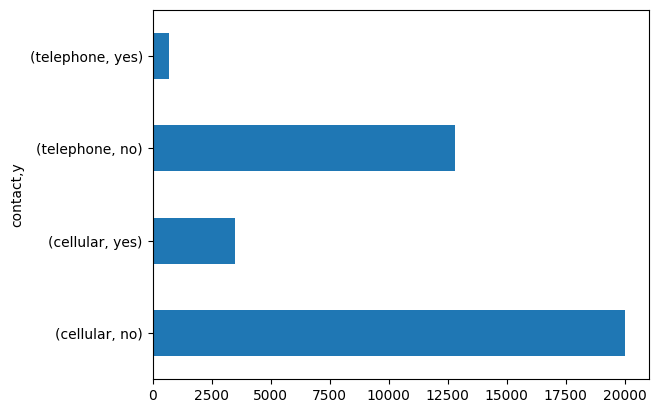

In [18]:
df.groupby('contact')['y'].value_counts().plot(kind='barh')

In [19]:
df.groupby('poutcome')['y'].value_counts()

poutcome     y  
failure      no      3269
             yes      548
nonexistent  no     29132
             yes     2837
success      yes      815
             no       423
Name: count, dtype: int64

- There are more number of non-existent records of customers who have opted out of the campaign. The previous campaign success numbers was in total of 1228 out of which 815 customers have opted for the term deposit, which would not make enough or significant impact on the classification model

#### Changing the characteristics of state and city code into the numerical columns

In [20]:
df['state_code'] = df['state_code'].apply(lambda x: x[1:]).astype('int64')
df['city_code'] = df['city_code'].apply(lambda x: x[1:]).astype('int64')

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37024 entries, 0 to 37023
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             37024 non-null  int64  
 1   job             37024 non-null  object 
 2   marital         37024 non-null  object 
 3   education       37024 non-null  object 
 4   default         37024 non-null  object 
 5   housing         37024 non-null  object 
 6   loan            37024 non-null  object 
 7   region_code     37024 non-null  int64  
 8   state_code      37024 non-null  int64  
 9   city_code       37024 non-null  int64  
 10  contact         37024 non-null  object 
 11  month           37024 non-null  object 
 12  day_of_week     37024 non-null  object 
 13  duration        37024 non-null  int64  
 14  campaign        37024 non-null  int64  
 15  pdays           37024 non-null  int64  
 16  previous        37024 non-null  int64  
 17  poutcome        37024 non-null 

In [25]:
df.groupby(['state_name'])['y'].value_counts().sort_values(ascending=False)

state_name     y  
California     no     6540
New York       no     3719
Texas          no     3224
Pennsylvania   no     1969
Washington     no     1645
                      ... 
South Dakota   yes       3
Wyoming        no        3
Montana        yes       2
West Virginia  yes       1
Wyoming        yes       1
Name: count, Length: 98, dtype: int64

- Hence Region name and State name and City name would not play a much significant role in deciding the customers for the term deposit plan we can drop these columns

In [26]:
df.drop(['region_name', 'state_name', 'city_name'], axis=1, inplace=True)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37024 entries, 0 to 37023
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             37024 non-null  int64  
 1   job             37024 non-null  object 
 2   marital         37024 non-null  object 
 3   education       37024 non-null  object 
 4   default         37024 non-null  object 
 5   housing         37024 non-null  object 
 6   loan            37024 non-null  object 
 7   region_code     37024 non-null  int64  
 8   state_code      37024 non-null  int64  
 9   city_code       37024 non-null  int64  
 10  contact         37024 non-null  object 
 11  month           37024 non-null  object 
 12  day_of_week     37024 non-null  object 
 13  duration        37024 non-null  int64  
 14  campaign        37024 non-null  int64  
 15  pdays           37024 non-null  int64  
 16  previous        37024 non-null  int64  
 17  poutcome        37024 non-null 

#### Fitting the outliers in the single domain using winsorization

<Axes: ylabel='age'>

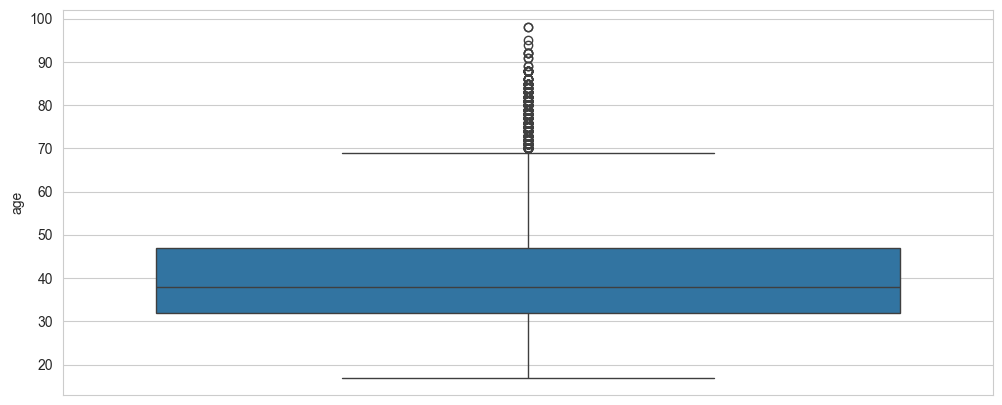

In [35]:
sb.boxplot(df['age'])

In [37]:
def winsorize_with_iqr(df, column):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Determine lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Create a new column with Winsorized values
    df[column] = df[column].apply(
        lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x)
    )
    
    return df


In [38]:
df = winsorize_with_iqr(df, 'age')

#### Constructing new features using the available features like - emp.var.rate, cons.price.idx, cons.conf.idx

In [41]:
df['employment_indicator'] = df['emp.var.rate'] * df['nr.employed']
df['consumer_index'] = df['cons.price.idx'] + df['cons.conf.idx']
df['economic_sentiment'] = df['emp.var.rate'] + df['cons.price.idx'] + df['cons.conf.idx']
df['interest_rate_impact'] = df['euribor3m'] * df['emp.var.rate']

In [43]:
df.drop(['cons.conf.idx', 'emp.var.rate', 'euribor3m', 'cons.price.idx', 'nr.employed'], axis=1, inplace=True)

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37024 entries, 0 to 37023
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   37024 non-null  float64
 1   job                   37024 non-null  object 
 2   marital               37024 non-null  object 
 3   education             37024 non-null  object 
 4   default               37024 non-null  object 
 5   housing               37024 non-null  object 
 6   loan                  37024 non-null  object 
 7   region_code           37024 non-null  int64  
 8   state_code            37024 non-null  int64  
 9   city_code             37024 non-null  int64  
 10  contact               37024 non-null  object 
 11  month                 37024 non-null  object 
 12  day_of_week           37024 non-null  object 
 13  duration              37024 non-null  int64  
 14  campaign              37024 non-null  int64  
 15  pdays              

In [48]:
df.corr(numeric_only=True)

,age,region_code,state_code,city_code,duration,campaign,pdays,previous,postal code,employment_indicator,consumer_index,economic_sentiment,interest_rate_impact
age,1.000000,-0.005540,-0.001665,0.003184,-0.002494,0.005186,-0.027557,0.014503,-0.003085,0.013244,0.125283,0.113257,0.026425
region_code,-0.005540,1.000000,-0.254505,-0.055221,0.007062,-0.004651,-0.004676,-0.002017,0.476932,-0.004159,-0.001980,-0.002958,-0.004560
state_code,-0.001665,-0.254505,1.000000,0.269819,-0.000433,-0.011535,-0.000757,0.009699,-0.483615,-0.002099,-0.001204,-0.001657,-0.003928
city_code,0.003184,-0.055221,0.269819,1.000000,0.003893,-0.012439,-0.015129,0.011874,-0.045588,-0.014344,-0.003871,-0.007621,-0.012388
duration,-0.002494,0.007062,-0.000433,0.003893,1.000000,-0.072433,-0.048505,0.022269,0.005673,-0.030402,-0.008346,-0.016235,-0.026835
campaign,0.005186,-0.004651,-0.011535,-0.012439,-0.072433,1.000000,0.052723,-0.078426,-0.006401,0.150908,0.003459,0.047034,0.164404
pdays,-0.027557,-0.004676,-0.000757,-0.015129,-0.048505,0.052723,1.000000,-0.586947,-0.002188,0.268931,-0.078891,0.010261,0.225017
previous,0.014503,-0.002017,0.009699,0.011874,0.022269,-0.078426,-0.586947,1.000000,-0.001942,-0.417610,-0.075466,-0.188485,-0.401511
postal code,-0.003085,0.476932,-0.483615,-0.045588,0.005673,-0.006401,-0.002188,-0.001942,1.000000,-0.005525,0.000355,-0.001311,-0.005772
employment_indicator,0.013244,-0.004159,-0.002099,-0.014344,-0.030402,0.150908,0.268931,-0.417610,-0.005525,1.000000,0.295899,0.551302,0.959663


- From the above correlation we can see that Region_code, State_code, City_code doesnt preform well with the most of the columns and would need to be dropped before considering for training

#### Finally Encoding the Columns based on their characteristics

In [50]:
df.head()

,age,job,marital,education,default,housing,loan,region_code,state_code,city_code,...,campaign,pdays,previous,poutcome,postal code,y,employment_indicator,consumer_index,economic_sentiment,interest_rate_impact
0,56.0,services,married,high.school,no,no,yes,3,1,1,...,1,999,0,nonexistent,42420,no,5710.1,57.594,58.694,5.3427
1,45.0,services,married,basic.9y,unknown,no,no,3,1,1,...,1,999,0,nonexistent,42420,no,5710.1,57.594,58.694,5.3427
2,59.0,admin.,married,professional.course,no,no,no,4,2,2,...,1,999,0,nonexistent,90036,no,5710.1,57.594,58.694,5.3427
3,41.0,blue-collar,married,unknown,unknown,no,no,3,3,3,...,1,999,0,nonexistent,33311,no,5710.1,57.594,58.694,5.3427
4,24.0,technician,single,professional.course,no,yes,no,3,3,3,...,1,999,0,nonexistent,33311,no,5710.1,57.594,58.694,5.3427


In [59]:
cat_cols = df.select_dtypes('object').columns[:-1]
cat_cols

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome'],
      dtype='object')

In [65]:
ohe = OneHotEncoder(drop='first')
ohe_cols = ohe.fit_transform(df[cat_cols])
ohe_cols_df = DataFrame(ohe_cols.todense(), columns=ohe.get_feature_names_out())
df = pd.concat([df.drop(cat_cols, axis=1), ohe_cols_df], axis=1)
df

,age,region_code,state_code,city_code,duration,campaign,pdays,previous,postal code,y,...,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,56.0,3,1,1,307,1,999,0,42420,no,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,45.0,3,1,1,198,1,999,0,42420,no,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,59.0,4,2,2,139,1,999,0,90036,no,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,41.0,3,3,3,217,1,999,0,33311,no,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,24.0,3,3,3,380,1,999,0,33311,no,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37019,69.5,2,16,21,334,1,999,0,10009,yes,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
37020,46.0,2,16,21,383,1,999,0,10011,no,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
37021,56.0,2,16,21,189,2,999,0,10009,no,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
37022,44.0,4,17,49,442,1,999,0,85254,yes,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


#### Running a Lable Encoder on the output column

In [67]:
labels = LabelEncoder()
y = labels.fit_transform(df['y'])
df['y'] = y

In [69]:
labels.classes_

array(['no', 'yes'], dtype=object)

In [68]:
df

,age,region_code,state_code,city_code,duration,campaign,pdays,previous,postal code,y,...,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,56.0,3,1,1,307,1,999,0,42420,0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,45.0,3,1,1,198,1,999,0,42420,0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,59.0,4,2,2,139,1,999,0,90036,0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,41.0,3,3,3,217,1,999,0,33311,0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,24.0,3,3,3,380,1,999,0,33311,0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37019,69.5,2,16,21,334,1,999,0,10009,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
37020,46.0,2,16,21,383,1,999,0,10011,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
37021,56.0,2,16,21,189,2,999,0,10009,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
37022,44.0,4,17,49,442,1,999,0,85254,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37024 entries, 0 to 37023
Data columns (total 57 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            37024 non-null  float64
 1   region_code                    37024 non-null  int64  
 2   state_code                     37024 non-null  int64  
 3   city_code                      37024 non-null  int64  
 4   duration                       37024 non-null  int64  
 5   campaign                       37024 non-null  int64  
 6   pdays                          37024 non-null  int64  
 7   previous                       37024 non-null  int64  
 8   postal code                    37024 non-null  int64  
 9   y                              37024 non-null  int32  
 10  employment_indicator           37024 non-null  float64
 11  consumer_index                 37024 non-null  float64
 12  economic_sentiment             37024 non-null 

#### We can run a VIF or RFE to check for important features

In [77]:
vif = DataFrame()
vif['features'] = df.columns
vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]

C:\Users\z046368\AppData\Roaming\Python\Python312\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [78]:
vif[vif['VIF'] > 10]

,features,VIF
0,age,2.65e+01
6,pdays,1.90e+02
10,employment_indicator,1.48e+05
11,consumer_index,1.62e+08
12,economic_sentiment,1.63e+08
13,interest_rate_impact,2.61e+02
37,housing_unknown,inf
39,loan_unknown,inf
55,poutcome_nonexistent,3.28e+01


#### Out of these features we can remove any of the two features as there are two undefined VIF metrics

In [79]:
df.drop(['housing_unknown', 'loan_unknown'], axis=1, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37024 entries, 0 to 37023
Data columns (total 55 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            37024 non-null  float64
 1   region_code                    37024 non-null  int64  
 2   state_code                     37024 non-null  int64  
 3   city_code                      37024 non-null  int64  
 4   duration                       37024 non-null  int64  
 5   campaign                       37024 non-null  int64  
 6   pdays                          37024 non-null  int64  
 7   previous                       37024 non-null  int64  
 8   postal code                    37024 non-null  int64  
 9   y                              37024 non-null  int32  
 10  employment_indicator           37024 non-null  float64
 11  consumer_index                 37024 non-null  float64
 12  economic_sentiment             37024 non-null 

In [83]:
# X = df.drop('y', axis=1)
# y = df['y']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,random_state=42, shuffle=True, stratify=y)

In [86]:
# param_grid = {
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'bootstrap': [True, False],
# }

# rf = RandomForestClassifier(n_estimators=250, max_depth=10)

# # Set up GridSearchCV
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
#                            scoring='precision', n_jobs=-1, cv=3, verbose=2)

# # Fit the model to find the best hyperparameters
# grid_search.fit(X_train, y_train)

# # Print best hyperparameters
# print("Best Hyperparameters:")
# print(grid_search.best_params_)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


C:\Users\z046368\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
54 fits failed out of a total of 162.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\z046368\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\z046368\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\z046368\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py", line 666, in _validate_params
  

Best Hyperparameters:
{'bootstrap': True, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10}


- After careful validation RandomForest the hyperparameters that would be better for tree based algorithms are {'bootstrap': True, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10}

In [89]:
(df['y'].value_counts() / len(df)) * 100

y
0    88.66
1    11.34
Name: count, dtype: float64

- The baseline accuracy for the dataset would be around 88% as there is bias and more number of "Not opted" plans

In [96]:
synthetic_df = df.copy()

#### Using SMOTE for creating balance in the class label

In [97]:
from imblearn.over_sampling import SMOTE

X = df.drop('y', axis=1)
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42, shuffle=True, stratify=y)

smote = SMOTE(random_state=42)

# Fit SMOTE on the training data
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Convert back to DataFrame if needed
df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled['y'] = y_resampled


In [98]:
synthetic_df = pd.concat([synthetic_df, df_resampled])

In [100]:
synthetic_df['y'].value_counts()

y
0    55800
1    27176
Name: count, dtype: int64

#### Using RFE on Original Dataset for selecting the best features

In [101]:
X = df.drop('y', axis=1)
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the RandomForestClassifier
estimator = RandomForestClassifier(n_estimators=200, bootstrap=True, max_features='log2', min_samples_leaf=2, min_samples_split=10, random_state=42)

In [103]:
# Initialize RFE and select the top 2 features
selector = RFE(estimator, n_features_to_select=20)
selector = selector.fit(X_train, y_train)

# Get the selected features
selected_features = X.columns[selector.support_]
print("Selected Features:")
print(selected_features)

Selected Features:
Index(['age', 'region_code', 'state_code', 'city_code', 'duration', 'campaign',
       'pdays', 'previous', 'postal code', 'employment_indicator',
       'consumer_index', 'economic_sentiment', 'interest_rate_impact',
       'marital_married', 'education_university.degree', 'housing_yes',
       'contact_telephone', 'month_may', 'poutcome_nonexistent',
       'poutcome_success'],
      dtype='object')


In [104]:
X = synthetic_df.drop('y', axis=1)
y = synthetic_df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the RandomForestClassifier
estimator = RandomForestClassifier(n_estimators=200, bootstrap=True, max_features='log2', min_samples_leaf=2, min_samples_split=10, random_state=42)

In [105]:
# Initialize RFE and select the top 2 features
selector = RFE(estimator, n_features_to_select=20)
selector = selector.fit(X_train, y_train)

# Get the selected features
selected_features = X.columns[selector.support_]
print("Selected Features:")
print(selected_features)

Selected Features:
Index(['age', 'state_code', 'city_code', 'duration', 'pdays', 'postal code',
       'employment_indicator', 'consumer_index', 'economic_sentiment',
       'interest_rate_impact', 'job_blue-collar', 'marital_married',
       'marital_single', 'education_high.school',
       'education_university.degree', 'housing_yes', 'contact_telephone',
       'month_may', 'poutcome_nonexistent', 'poutcome_success'],
      dtype='object')


In [110]:
synthetic_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 82976 entries, 0 to 45951
Data columns (total 55 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            82976 non-null  float64
 1   region_code                    82976 non-null  int64  
 2   state_code                     82976 non-null  int64  
 3   city_code                      82976 non-null  int64  
 4   duration                       82976 non-null  int64  
 5   campaign                       82976 non-null  int64  
 6   pdays                          82976 non-null  int64  
 7   previous                       82976 non-null  int64  
 8   postal code                    82976 non-null  int64  
 9   y                              82976 non-null  int32  
 10  employment_indicator           82976 non-null  float64
 11  consumer_index                 82976 non-null  float64
 12  economic_sentiment             82976 non-null  floa

In [111]:
df.to_csv('original_dataset.csv', index=False)
synthetic_df.to_csv('synthetic_df.csv', index=False)